In [21]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
import time

from keras.datasets import mnist
from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential


In [22]:
#Load Data
(xTrain, _),(_,_) = mnist.load_data()

In [23]:
#reshape and normalise data
xTrain = xTrain.reshape(xTrain.shape[0],28,28,1).astype("float32")
xTrain = (xTrain - 127.5)/127.5 #tanh -->[-1,1]
len(xTrain)

60000

In [24]:
batchSize = 256
trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

In [25]:
nepochs = 100
zDim = 100
imgShape = [28,28,1]
sampleInterval = 5

In [26]:
def buildGenerator():

    model = Sequential()
    model.add(Dense(256 * 7 * 7,  input_shape=(zDim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape([7, 7, 256]))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=3, padding='same', activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [27]:
buildGenerator().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_8 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 14, 14, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 14, 14, 128)     

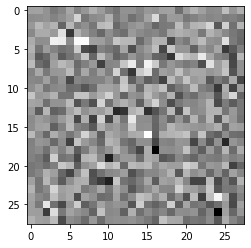

In [28]:
#generate noise image
generator = buildGenerator()

noise = tf.random.normal([1, zDim])
generatedImage = generator(noise,training = False)
plt.imshow(generatedImage[0, :, :, 0], cmap='gray')
plt.show()

In [29]:
#Discriminator
def buildDiscriminator():

    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=imgShape,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(256,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [30]:
buildDiscriminator().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 128)        

In [31]:
#classyfy with discriminator
discriminator = buildDiscriminator()
decision = discriminator(generatedImage,training=False)
print (decision)

tf.Tensor([[0.49979457]], shape=(1, 1), dtype=float32)


In [32]:
def buildGan(generator,discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [33]:
buildGan(generator,discriminator).summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 28, 28, 1)         1705601   
                                                                 
 sequential_9 (Sequential)   (None, 1)                 388865    
                                                                 
Total params: 2,094,466
Trainable params: 2,068,930
Non-trainable params: 25,536
_________________________________________________________________


In [34]:
gan = buildGan(generator,discriminator)
decision = gan(noise,training = False)
print(decision)

tf.Tensor([[0.49979457]], shape=(1, 1), dtype=float32)


In [35]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="adam")

In [36]:
def train_step(images):
    noise = tf.random.normal([len(images),zDim])
    genImg = generator(noise)

    real = tf.ones([len(images),1])
    fake = tf.zeros([len(images),1])
    #for i in range(3):
    discriminator.trainable = True
    dreal = discriminator.train_on_batch(images,real)
    dfake = discriminator.train_on_batch(genImg, fake)
    disLoss, acc = 0.5*tf.add(dreal,dfake)
    
    discriminator.trainable = False
    genLoss = gan.train_on_batch(noise,real)

      
    return genLoss,disLoss,acc*100

In [37]:
def training():
    for epoch in range(nepochs):
      start = time.time()

      for batch in trainDataset:
        train_step(batch)
        genLoss,disLoss,acc = train_step(batch)
        
      if (epoch + 1) % sampleInterval ==0:
        print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
        print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
        sampleImg(generator)

In [38]:
def sampleImg(generator,imgGridRow = 4, imgGridColumn = 4):
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)
    genImg = 127.5*genImg+127.5

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(4,4),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt,:,:,0],cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

Time for epoch 5 is 47.0 sec
Epoch:  5 | Discriminator Loss:  0.29 | Accuracy:  88.54 % | Generator Loss:  2.58
---------------------------------------------------------------------------------------------------------------------------------------------------------------


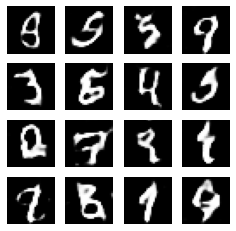

Time for epoch 10 is 47.0 sec
Epoch:  10 | Discriminator Loss:  0.47 | Accuracy:  76.04 % | Generator Loss:  1.85
---------------------------------------------------------------------------------------------------------------------------------------------------------------


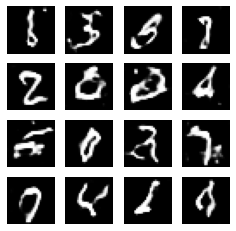

Time for epoch 15 is 47.0 sec
Epoch:  15 | Discriminator Loss:  0.56 | Accuracy:  76.04 % | Generator Loss:  1.56
---------------------------------------------------------------------------------------------------------------------------------------------------------------


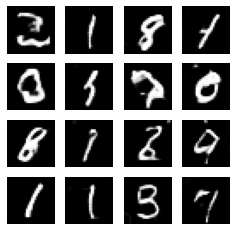

Time for epoch 20 is 47.0 sec
Epoch:  20 | Discriminator Loss:  0.54 | Accuracy:  73.96 % | Generator Loss:  1.54
---------------------------------------------------------------------------------------------------------------------------------------------------------------


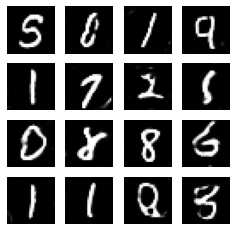

Time for epoch 25 is 47.0 sec
Epoch:  25 | Discriminator Loss:  0.6 | Accuracy:  70.83 % | Generator Loss:  1.32
---------------------------------------------------------------------------------------------------------------------------------------------------------------


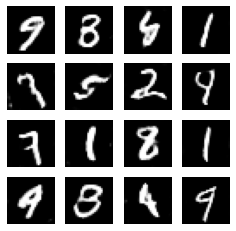

Time for epoch 30 is 47.0 sec
Epoch:  30 | Discriminator Loss:  0.44 | Accuracy:  78.65 % | Generator Loss:  1.52
---------------------------------------------------------------------------------------------------------------------------------------------------------------


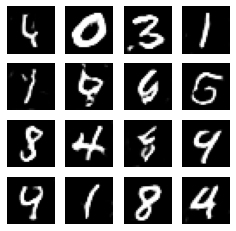

Time for epoch 35 is 47.0 sec
Epoch:  35 | Discriminator Loss:  0.46 | Accuracy:  81.25 % | Generator Loss:  1.47
---------------------------------------------------------------------------------------------------------------------------------------------------------------


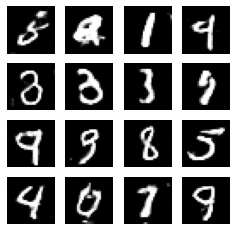

Time for epoch 40 is 47.0 sec
Epoch:  40 | Discriminator Loss:  0.61 | Accuracy:  65.1 % | Generator Loss:  1.01
---------------------------------------------------------------------------------------------------------------------------------------------------------------


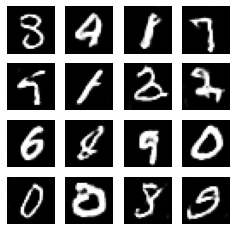

Time for epoch 45 is 47.0 sec
Epoch:  45 | Discriminator Loss:  0.56 | Accuracy:  73.96 % | Generator Loss:  1.22
---------------------------------------------------------------------------------------------------------------------------------------------------------------


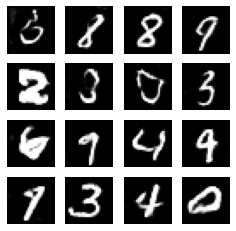

Time for epoch 50 is 47.0 sec
Epoch:  50 | Discriminator Loss:  0.56 | Accuracy:  69.79 % | Generator Loss:  1.25
---------------------------------------------------------------------------------------------------------------------------------------------------------------


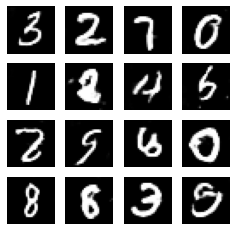

Time for epoch 55 is 47.0 sec
Epoch:  55 | Discriminator Loss:  0.52 | Accuracy:  74.48 % | Generator Loss:  1.18
---------------------------------------------------------------------------------------------------------------------------------------------------------------


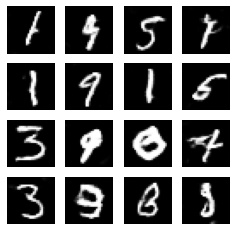

Time for epoch 60 is 47.0 sec
Epoch:  60 | Discriminator Loss:  0.66 | Accuracy:  61.46 % | Generator Loss:  1.02
---------------------------------------------------------------------------------------------------------------------------------------------------------------


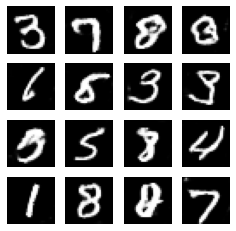

Time for epoch 65 is 47.0 sec
Epoch:  65 | Discriminator Loss:  0.5 | Accuracy:  76.04 % | Generator Loss:  1.08
---------------------------------------------------------------------------------------------------------------------------------------------------------------


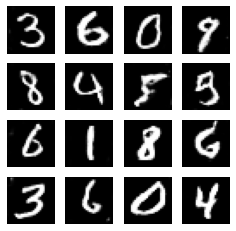

Time for epoch 70 is 47.0 sec
Epoch:  70 | Discriminator Loss:  0.59 | Accuracy:  67.71 % | Generator Loss:  1.06
---------------------------------------------------------------------------------------------------------------------------------------------------------------


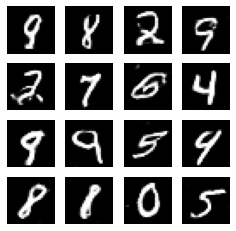

Time for epoch 75 is 47.0 sec
Epoch:  75 | Discriminator Loss:  0.62 | Accuracy:  65.1 % | Generator Loss:  0.96
---------------------------------------------------------------------------------------------------------------------------------------------------------------


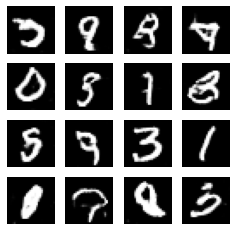

Time for epoch 80 is 47.0 sec
Epoch:  80 | Discriminator Loss:  0.68 | Accuracy:  59.9 % | Generator Loss:  0.95
---------------------------------------------------------------------------------------------------------------------------------------------------------------


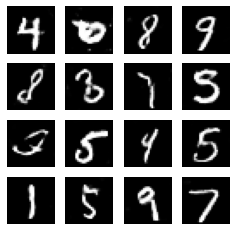

Time for epoch 85 is 47.0 sec
Epoch:  85 | Discriminator Loss:  0.62 | Accuracy:  65.62 % | Generator Loss:  1.07
---------------------------------------------------------------------------------------------------------------------------------------------------------------


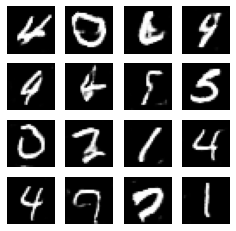

Time for epoch 90 is 47.0 sec
Epoch:  90 | Discriminator Loss:  0.56 | Accuracy:  68.75 % | Generator Loss:  1.08
---------------------------------------------------------------------------------------------------------------------------------------------------------------


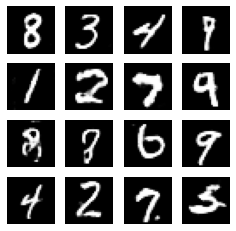

Time for epoch 95 is 47.0 sec
Epoch:  95 | Discriminator Loss:  0.64 | Accuracy:  62.5 % | Generator Loss:  1.02
---------------------------------------------------------------------------------------------------------------------------------------------------------------


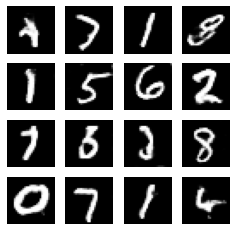

Time for epoch 100 is 45.0 sec
Epoch:  100 | Discriminator Loss:  0.63 | Accuracy:  64.58 % | Generator Loss:  0.91
---------------------------------------------------------------------------------------------------------------------------------------------------------------


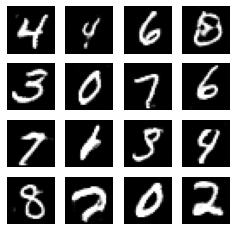

In [39]:
training()

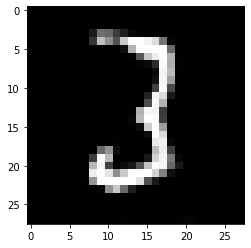

In [68]:
noise = tf.random.normal([batchSize, zDim])
genImg = generator.predict(noise)
genImg = 127.5*genImg+127.5
plt.imshow(genImg[0,:,:,0],cmap="gray")
plt.show()


In [72]:
generator.compile(loss="binary_crossentropy",optimizer="adam")
generator.save("MNIST_mlpgenerator")

discriminator.save("MNIST_mlpdiscriminator")

gan.save("MNIST_mlpgan")

INFO:tensorflow:Assets written to: MNIST_mlpgenerator\assets
INFO:tensorflow:Assets written to: MNIST_mlpdiscriminator\assets
INFO:tensorflow:Assets written to: MNIST_mlpgan\assets


In [73]:
model = K.models.load_model("MNIST_mlpgenerator")
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_12 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 128)      295040    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 14, 14, 128)     

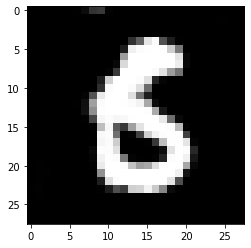

In [83]:
noise = tf.random.normal([256, 100])
genImg = model.predict(noise)
genImg = 127.5*genImg+127.5
plt.imshow(genImg[0,:,:,0],cmap="gray")
plt.show()